<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Long Short Term Memory (LSTM)

###Install dependencies

In [202]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Load Libraries

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle
import random as python_random

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define a function to get reproducable results in keras

In [204]:
def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds() 

###Define Functions to Facilitate Metrics Evaluation

In [205]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [206]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [207]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [208]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [209]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

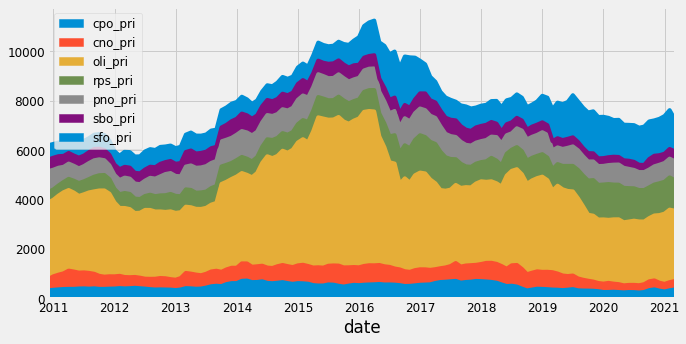

In [210]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Long Short Term Memory Forecasting Technique (LSTM)**

###**Split Data into Train Test Segments**

In [211]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [212]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [213]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [214]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [215]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [216]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [217]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [218]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [224]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


###LSTM Baseline Model Architecture


*  LSTM with 85 neurons in the first visible layer.
*  LSTM with 64 neurons in the second visible layer.
*  1 neuron in the output layer for predicting crude palm oil price.
*  The input shape will be 3 time step with 7 features.
*   I apply the Mean Squared Error (MSE) loss function and the efficient Adam version of stochastic gradient descent.
*  Fit the model for 100 training epochs with a batch size of 64.


In [228]:
LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.LSTM(units=85, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
LSTM_model.add(tf.keras.layers.Dense(64, activation='tanh'))
LSTM_model.add(tf.keras.layers.Dense(1))

# compile model using adam
LSTM_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 64, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
LSTM_model.evaluate(X_test, y_test)

Epoch 1/100
2/2 [==============================] - 4s 909ms/step - loss: 0.1905 - mse: 0.1905 - val_loss: 0.1973 - val_mse: 0.1973
Epoch 2/100
2/2 [==============================] - 0s 80ms/step - loss: 0.0811 - mse: 0.0811 - val_loss: 0.1074 - val_mse: 0.1074
Epoch 3/100
2/2 [==============================] - 0s 60ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 4/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0847 - val_mse: 0.0847
Epoch 5/100
2/2 [==============================] - 0s 78ms/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0869 - val_mse: 0.0869
Epoch 6/100
2/2 [==============================] - 0s 142ms/step - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 7/100
2/2 [==============================] - 0s 207ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0702 - val_mse: 0.0702
Epoch 8/100
2/2 [==============================] - 0s 201ms/step - loss: 0.0224 - mse: 

[0.013051954098045826, 0.013051954098045826]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


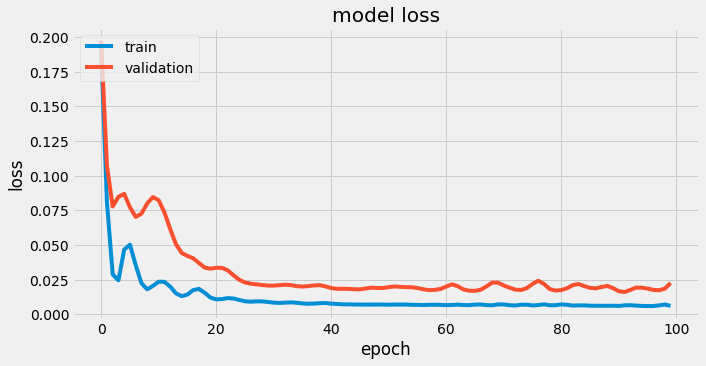

In [230]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [231]:
mse_LSTM = LSTM_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 32ms/step - loss: 0.0131 - mse: 0.0131


####Baseline LSTM MSE = 0.0131

In [232]:
LSTM_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 85)                31620     
                                                                 
 dense_24 (Dense)            (None, 64)                5504      
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 37,189
Trainable params: 37,189
Non-trainable params: 0
_________________________________________________________________


###Predict the Test without Hyperparameter Tuning

In [233]:
y_pred = LSTM_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 461ms/step


array([[ 0.12823585],
       [ 0.12328459],
       [ 0.1433386 ],
       [ 0.12368794],
       [ 0.09280807],
       [ 0.05983951],
       [ 0.04285938],
       [ 0.0161758 ],
       [-0.02609681],
       [-0.04843174],
       [-0.04938041],
       [-0.04967274],
       [-0.06553654],
       [-0.07062273],
       [-0.07711754],
       [-0.09555092],
       [-0.09778533],
       [-0.02232313],
       [ 0.06960752],
       [ 0.08388764],
       [ 0.04015286],
       [ 0.03269188]], dtype=float32)

In [234]:
y_pred.reshape(1,-1)

array([[ 0.12823585,  0.12328459,  0.1433386 ,  0.12368794,  0.09280807,
         0.05983951,  0.04285938,  0.0161758 , -0.02609681, -0.04843174,
        -0.04938041, -0.04967274, -0.06553654, -0.07062273, -0.07711754,
        -0.09555092, -0.09778533, -0.02232313,  0.06960752,  0.08388764,
         0.04015286,  0.03269188]], dtype=float32)

###Invert Transformed Data

In [235]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[370.29434 368.31384 376.33545 368.4752  356.12323 342.9358  336.14377
  325.47034 308.56128 299.62732 299.24783 299.1309  292.78537 290.75092
  288.15298 280.77963 279.88586 310.07074 346.84302 352.55505 335.06116
  332.07675]]


###Plot History, Actual and Predicted Value

In [236]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [237]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [238]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([370.29434, 368.31384, 376.33545, 368.4752 , 356.12323, 342.9358 ,
       336.14377, 325.47034, 308.56128, 299.62732, 299.24783, 299.1309 ,
       292.78537, 290.75092, 288.15298, 280.77963, 279.88586, 310.07074,
       346.84302, 352.55505, 335.06116, 332.07675], dtype=float32)

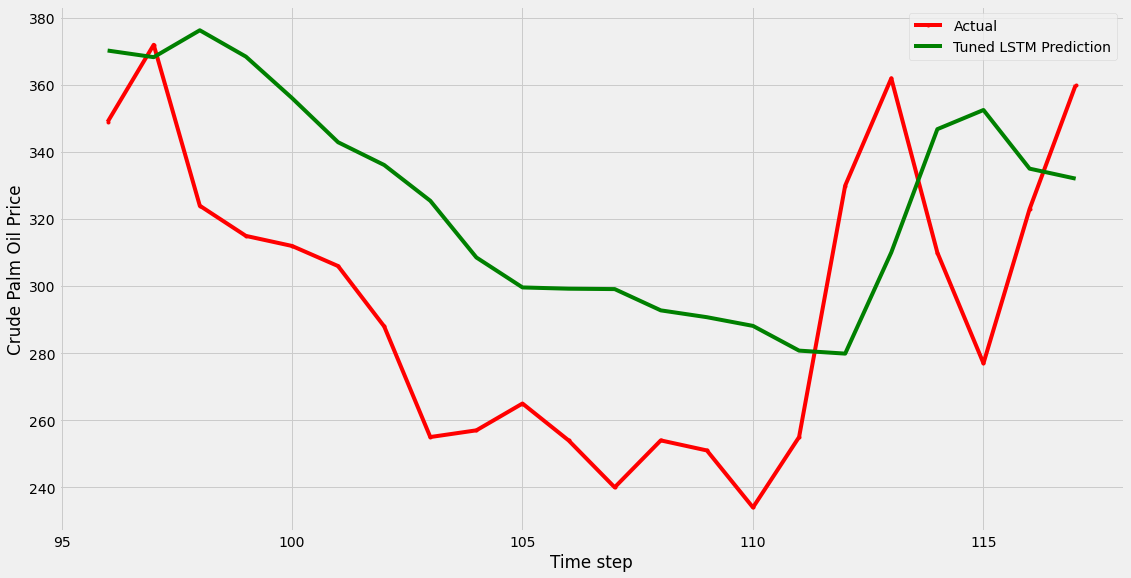

In [239]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="Tuned LSTM Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()

###Evaluate LSTM Model Accuracy

In [240]:
MAE_LSTM = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the LSTM Model is:', MAE_LSTM)

MDA_LSTM = mda(y_test_inv, y_pred_inv)
print('MDA value of the LSTM Model is:', MDA_LSTM)

MAPE_LSTM = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the LSTM Model is:', MAPE_LSTM)

RMSE_LSTM = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the LSTM Model is:', RMSE_LSTM)

MSE_LSTM = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the LSTM Model is:', MSE_LSTM)

#EVS_LSTM = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the LSTM Model is:', EVS_LSTM)

MAE value of the LSTM Model is: 42.451198231090196
MDA value of the LSTM Model is: 0.47619047619047616
MAPE value of the LSTM Model is: 15.041338620383407
RMSE value of the LSTM Model is: 45.6980621949803
MSE value of the LSTM Model is: 2088.312888376288


###Tuning LSTM with Keras Tuner

Define A Model-Building Class

In [241]:
#class ANNhypermodel(HyperModel):
class LSTMHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
      
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)
        hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2))
        model.add(keras.layers.Dense(units=hp_units_3))
        model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        #batch_size = hp.Int('batch_size',8,16,24,32,40,48,56,64,72,80,88,96, step=8)
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'AdamW', 'nadam','sgd','adadelta','adagrad'])

        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

#hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
hypermodel = LSTMHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [242]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [243]:
tuner_rs.search(X_train, y_train, epochs=16, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [117]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 445ms/step - loss: 0.2457 - mae: 0.4825 - mse: 0.2457


####Random Search MSE = 0.2457

In [118]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 96,
 'units_3': 32,
 'dropout': 0.0,
 'optimizer': 'adadelta',
 'activation': 'Softmax',
 'batch_size': 88,
 'epoch': 35,
 'momentum': 0.81,
 'decay': 0.000200001,
 'learning_rate': 0.005241515692754444}

###Build Bayesian Optimization

In [121]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [122]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

ValueError: ignored

###Bayesian Optimization Search MSE = 0.1065

###Evaluate Bayesian Optimization

In [80]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 96,
 'dropout': 0.2,
 'optimizer': 'sgd',
 'activation': 'Softmax',
 'batch_size': 8,
 'epoch': 20,
 'momentum': 0.8,
 'decay': 0.000700001,
 'learning_rate': 0.001083033272419774}

In [123]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

ValueError: ignored

###Build HYPERBAND optimization

In [124]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [125]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [126]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


1747.5449204444885  secs


In [127]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
fourth layer is {best_hps.get('units_4')}
drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128,
second layer is 96 
third layer is 48 

drop out is 0.45
batch_size is 88
epoch is 95
optimizer is adagrad
activation is sigmoid

momentum is 0.8200000000000001
decay is 0.00010000100000000001

#learning rate is 0.0060388334626653275                                        

and the optimal learning rate for the optimizer
is 0.0060388334626653275.

[]
1/1 [==============================] - 1s 504ms/step - loss: 0.0117 - mae: 0.0953 - mse: 0.0117
loss:0.011739805340766907 mae: 0.09529677033424377 mse: 0.011739805340766907


In [148]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 128, 'units_2': 96, 'units_3': 48, 'dropout': 0.45, 'optimizer': 'adagrad', 'activation': 'sigmoid', 'batch_size': 88, 'epoch': 95, 'momentum': 0.8200000000000001, 'decay': 0.00010000100000000001, 'learning_rate': 0.0060388334626653275, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0148'}


###Apply the trained parameters to the LSTM

In [180]:
TULSTM_model = tf.keras.Sequential()
TULSTM_model.add(tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
TULSTM_model.add(tf.keras.layers.Dropout(rate=0.2))
TULSTM_model.add(tf.keras.layers.Dense(units=1))
TULSTM_model.compile(loss='mse', optimizer='adam')

In [191]:
TULSTM_model = tf.keras.Sequential()
TULSTM_model.add(tf.keras.layers.LSTM(units=128, activation='sigmoid', input_shape=(X_test.shape[1], X_test.shape[2])))
#TULSTM_model.add(layers.Dropout(0.45))
#TULSTM_model.add(tf.keras.layers.Dense(96, activation='sigmoid'))
#TULSTM_model.add(layers.Dropout(0.45))
#TULSTM_model.add(layers.Dropout(0.45))

#TULSTM_model.add(tf.keras.layers.Dense(48, activation='sigmoid'))
#TULSTM_model.add(layers.Dropout(0.45))
#TULSTM_model.add(tf.keras.layers.Dense(16))
#ULSTM_model.add(layers.Dropout(0.45))

#Output layer of model
TULSTM_model.add(tf.keras.layers.Dense(1))

In [192]:
TULSTM_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.legacy.Adagrad(learning_rate=0.006038, decay = 0.00010), metrics= ['mae', 'mse'])
#TULSTM_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),
history = TULSTM_model.fit(X_train, y_train, epochs=95, batch_size=88,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/95
1/1 [==============================] - 2s 2s/step - loss: 0.1374 - mae: 0.2927 - mse: 0.1374 - val_loss: 0.1685 - val_mae: 0.3605 - val_mse: 0.1685
Epoch 2/95
1/1 [==============================] - 0s 90ms/step - loss: 0.0821 - mae: 0.2444 - mse: 0.0821 - val_loss: 0.1395 - val_mae: 0.3336 - val_mse: 0.1395
Epoch 3/95
1/1 [==============================] - 0s 79ms/step - loss: 0.0673 - mae: 0.2284 - mse: 0.0673 - val_loss: 0.1277 - val_mae: 0.3219 - val_mse: 0.1277
Epoch 4/95
1/1 [==============================] - 0s 95ms/step - loss: 0.0630 - mae: 0.2207 - mse: 0.0630 - val_loss: 0.1224 - val_mae: 0.3160 - val_mse: 0.1224
Epoch 5/95
1/1 [==============================] - 0s 96ms/step - loss: 0.0617 - mae: 0.2171 - mse: 0.0617 - val_loss: 0.1197 - val_mae: 0.3133 - val_mse: 0.1197
Epoch 6/95
1/1 [==============================] - 0s 92ms/step - loss: 0.0613 - mae: 0.2157 - mse: 0.0613 - val_loss: 0.1184 - val_mae: 0.3120 - val_mse: 0.1184
Epoch 7/95
1/1 [====================

Plot Model Loss

<Figure size 720x360 with 0 Axes>

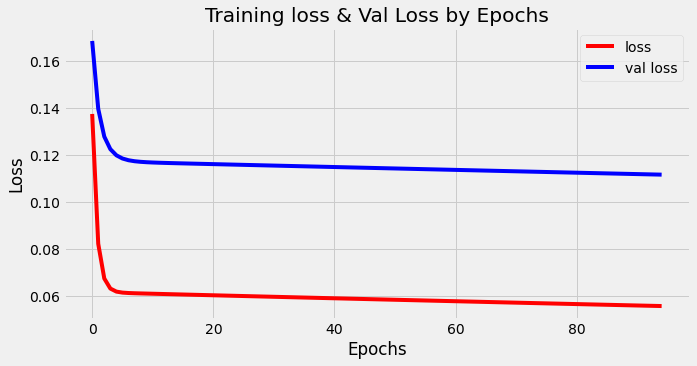

<Figure size 720x360 with 0 Axes>

In [193]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

In [194]:
y_predTU = TULSTM_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 176ms/step


array([[0.4308604 ],
       [0.43530065],
       [0.43892527],
       [0.4367719 ],
       [0.43759358],
       [0.44243774],
       [0.44304773],
       [0.43777388],
       [0.4349791 ],
       [0.43606383],
       [0.43655014],
       [0.4341998 ],
       [0.4325868 ],
       [0.43447766],
       [0.43250364],
       [0.4256036 ],
       [0.42544612],
       [0.44531024],
       [0.4507335 ],
       [0.44504538],
       [0.44129592],
       [0.44751966]], dtype=float32)

In [195]:
y_predTU.reshape(1,-1)

array([[0.4308604 , 0.43530065, 0.43892527, 0.4367719 , 0.43759358,
        0.44243774, 0.44304773, 0.43777388, 0.4349791 , 0.43606383,
        0.43655014, 0.4341998 , 0.4325868 , 0.43447766, 0.43250364,
        0.4256036 , 0.42544612, 0.44531024, 0.4507335 , 0.44504538,
        0.44129592, 0.44751966]], dtype=float32)

###Invert Transformed Tuned Data

In [196]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[491.34418 493.12024 494.5701  493.70874 494.03745 495.9751  496.21912
  494.10953 492.99164 493.4255  493.62006 492.67993 492.03473 492.79108
  492.00143 489.24146 489.17847 497.12408 499.29343 497.01816 495.51834
  498.00787]]


In [197]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [198]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [199]:
TU_LSTM_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_LSTM_Pred
TU_LSTM_Pred

array([491.34418, 493.12024, 494.5701 , 493.70874, 494.03745, 495.9751 ,
       496.21912, 494.10953, 492.99164, 493.4255 , 493.62006, 492.67993,
       492.03473, 492.79108, 492.00143, 489.24146, 489.17847, 497.12408,
       499.29343, 497.01816, 495.51834, 498.00787], dtype=float32)

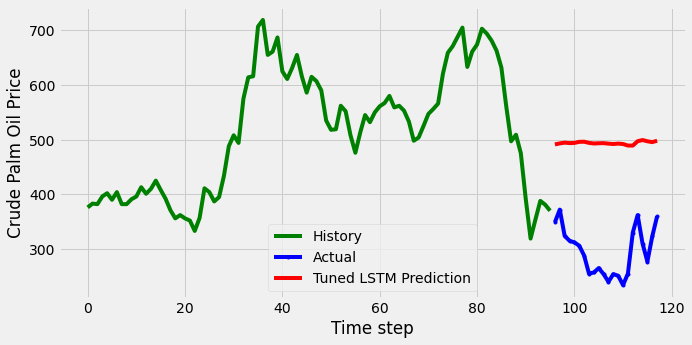

In [200]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_LSTM_Pred, color='red', label="Tuned LSTM Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

In [190]:
TUMAE_LSTM = mean_absolute_error(y_test_inv, TU_LSTM_Pred)
print('MAE value of the LSTM Model is:', TUMAE_LSTM)

TUMDA_LSTM = mda(y_test_inv, TU_LSTM_Pred)
print('MDA value of the tuned LSTM Model is:', TUMDA_LSTM)

TUMAPE_LSTM = mean_absolute_percentage_error(y_test_inv, TU_LSTM_Pred)
print('MAPE value of the tuned LSTM Model is:', TUMAPE_LSTM)

TURMSE_LSTM = mean_squared_error(y_test_inv,TU_LSTM_Pred, squared=False)
print('RMSE value of the tuned LSTM Model is:', TURMSE_LSTM)

TUMSE_LSTM = mean_squared_error(y_test_inv,TU_LSTM_Pred)
print('MSE value of the tuned LSTM Model is:', TUMSE_LSTM)

MAE value of the LSTM Model is: 93.42088456587358
MDA value of the tuned LSTM Model is: 0.42857142857142855
MAPE value of the tuned LSTM Model is: 33.63980043561035
RMSE value of the tuned LSTM Model is: 99.62276726673728
MSE value of the tuned LSTM Model is: 9924.6957578825


Compare tuned LSTM Actual VS Predicted (Zoomed-IN)

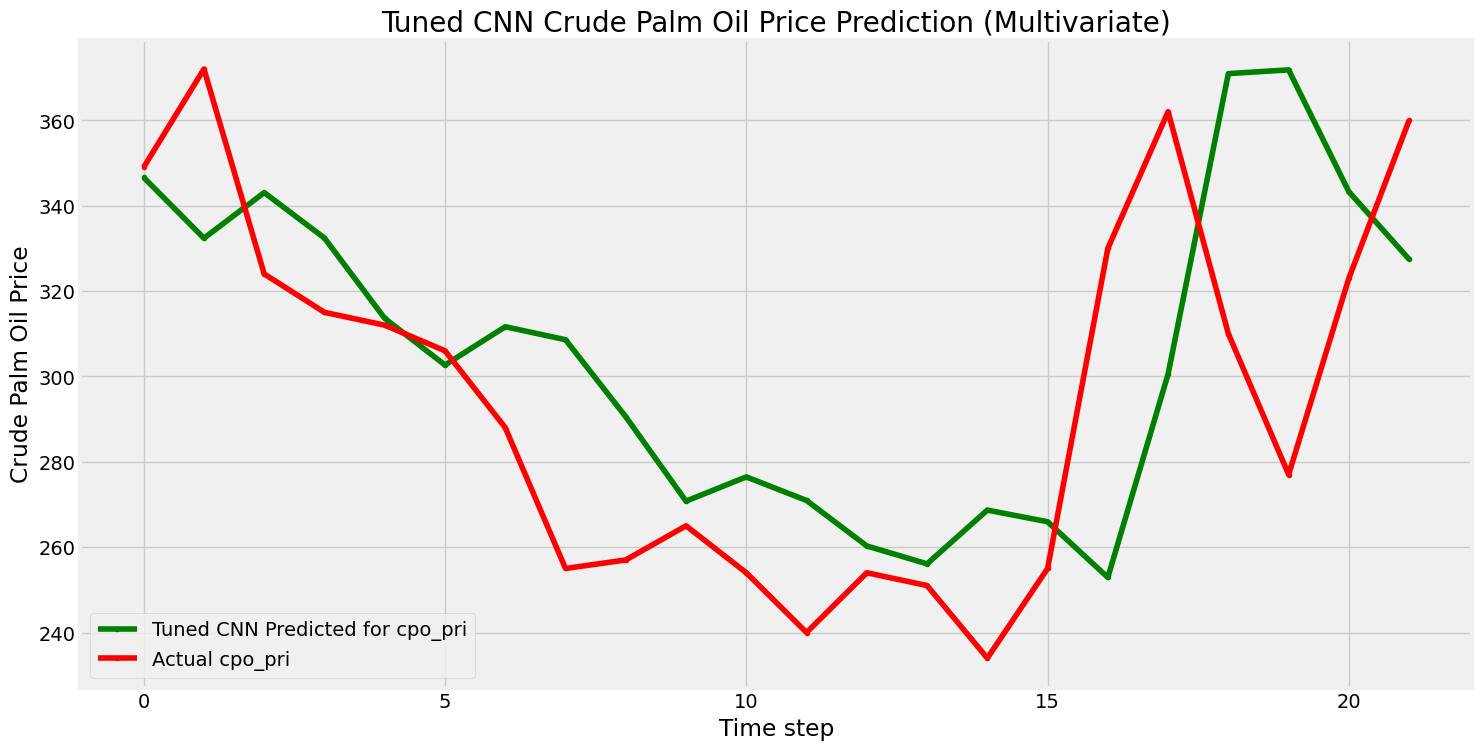

<Figure size 720x360 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
#plt.figure(figsize=(15,7))  #(10,6))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(TU_LSTM_Pred, color= 'green',marker='.',label = 'Tuned LSTM Predicted for cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Tuned LSTM Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Time step")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_TULSTM.png')

##Results

Baseline MSE         = 0.0160

Random search MSE    = 0.2349

Bayesian search MSE  = 0.3562

Hyperband search MSE = 0.0118

Baseline RSME        = 50.6

Tuned LSTM RSME       = 39.07

The tuned LSTM is superior to the basseline based on the RSME result

In [ ]:
TU_LSTM_Pred

array([347.44516, 340.68094, 350.3727 , 349.47916, 338.25525, 325.55246,
       326.9378 , 325.72952, 309.97247, 299.66055, 303.72882, 307.1458 ,
       296.03058, 283.43015, 286.5078 , 285.74634, 274.33182, 275.08328,
       328.6628 , 367.21143, 348.66684, 324.47903], dtype=float32)

In [ ]:
dfLSTM = pd.DataFrame(TU_LSTM_Pred)

print(df)

             0
0   346.603302
1   332.371765
2   343.059052
3   332.408813
4   313.587738
5   302.663574
6   311.632263
7   308.595581
8   290.542999
9   270.774170
10  276.457581
11  270.931183
12  260.275299
13  256.084198
14  268.680023
15  265.947815
16  252.900360
17  300.554657
18  370.926758
19  371.802551
20  343.249298
21  327.434967
